In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import trader as tr
import signaller as sg
import pylab as pl
import seaborn as sns

from sklearn.externals import joblib

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, ElasticNet, Lasso
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.mixture import GaussianMixture

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [18]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'MSFT', 'GOOG']
symbol = tickers[0]
window = 5
look_ahead = 1
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2016, 12, 31)
skip = True

In [19]:
if not skip:
    dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

    data = dataset.drop(labels=['Future Price'], axis=1)
    target = dataset['Future Price']

    dataset.head()

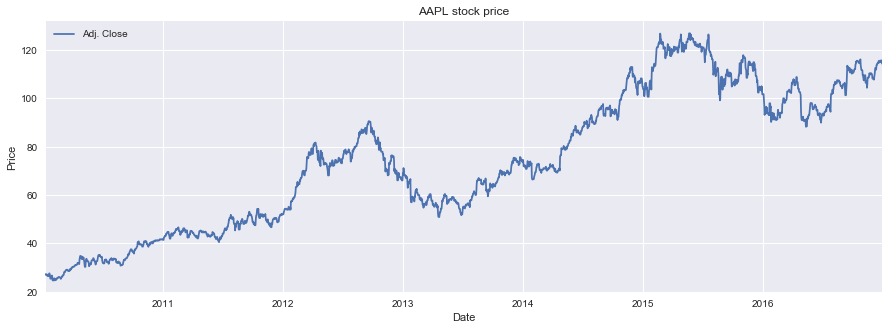

In [20]:
if not skip:
    data_frame = data[['Adj. Close']]
    ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(tickers[0]))

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')

## Find hyperparameters for model

In [4]:
if not skip:
    lasso = Lasso(random_state=rs)
    lasso_params = {'reg__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'reg__max_iter' : [1000, 10000, 100000, 1000000]}

    ridge = Ridge(random_state=rs)
    ridge_params = {'reg__alpha' : [10, 1, 0.1, 0.01, 0.001, 0.0001]}

    elasticnet = ElasticNet(random_state=rs)
    elasticnet_params = {'reg__alpha' : [10, 1, 0.1, 0.001, 0.0001], 'reg__l1_ratio' : [0.1, 0.3, 0.5, 0.9]}

    lin_reg = LinearRegression()

    models_params = [(lasso, lasso_params), (ridge, ridge_params), (elasticnet, elasticnet_params), (lin_reg, {})]

    scores = []
    estimators = []

    for model, params in models_params:
        class_name = model.__class__.__name__

        print ("\n{0}: \n".format(class_name))

        steps = [('scaler', StandardScaler()), ('reg', model)]
        pipe = Pipeline(steps)

        cv_splits = su.cross_val_splits(data, n_splits = 5)
        grid_search = GridSearchCV(pipe, params, cv = cv_splits)

        grid_search.fit(data, target)

        best_params = grid_search.best_params_
        print('best parameters: {0}'.format(best_params))

        best_score = grid_search.best_score_
        print('best score: {0}'.format(best_score))

        scores.append(best_score)

        best_estimator = grid_search.best_estimator_
        estimators.append(best_estimator)

## Generate training and testing datasets

In [5]:
if not skip:
    data = dataset.drop(labels=['Future Price'], axis=1)
    target = dataset['Future Price']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

    print ('Training set has {0} samples.'.format(X_train.shape[0]))
    print ('Testing set has {0} samples.'.format(X_test.shape[0]))

In [6]:
if not skip:    
    model_filenames = []
    for reg in estimators:
        class_name = reg.named_steps['reg'].__class__.__name__

        print ('\n{0}: \n'.format(class_name))

        reg.fit(X_train, y_train)

        print('score for training set: {0}'.format(reg.score(X_train, y_train)))

        su.print_cross_val_accuracy(reg, X_train, y_train)

        y_hat_test = reg.predict(X_test)
        print('score for test set: {0}'.format(reg.score(X_test, y_test)))

        su.print_cross_val_accuracy(reg, X_test, y_test)

        su.plot_predictions(class_name, y_test, y_hat_test)

        filename = '{0}.pkl'.format(class_name)
        model_filenames.append(filename)

        joblib.dump(reg, filename) 

## Generate a validation set and test the prediction accuracy

In [7]:
symbol = tickers[0]
window = 5
look_ahead = 1
valid_start_date = datetime.datetime(2017, 1, 1)
valid_end_date = datetime.datetime(2017, 8, 31)

valid_dataset = su.preprocess_data(symbol, window, look_ahead, valid_start_date, valid_end_date)

valid_dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2017-01-06,115.337596,116.700551,115.031425,116.453639,0.011148,115.128215,113.581518,116.674912,0.015153,116.453639
2017-01-07,115.337596,116.700551,115.031425,116.453639,0.000000,115.475867,113.638947,117.312787,0.015153,116.453639
2017-01-08,115.337596,116.700551,115.031425,116.453639,0.000000,115.823519,114.049355,117.597684,0.015153,117.520300
2017-01-09,116.493145,117.954865,116.483269,117.520300,0.009160,116.410183,114.743800,118.076566,0.025599,117.638817
2017-01-10,117.303017,117.905483,116.838822,117.638817,0.001008,116.904007,115.667780,118.140234,0.021439,118.270913


['ElasticNet.pkl', 'LinearRegression.pkl', 'Lasso.pkl', 'Ridge.pkl']

ElasticNet: 

score for validation set: 0.982847149327


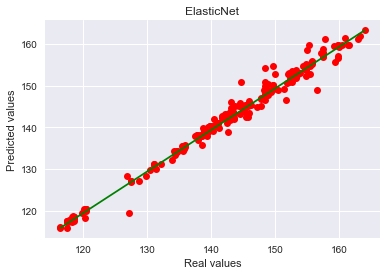


LinearRegression: 

score for validation set: 0.985197506525


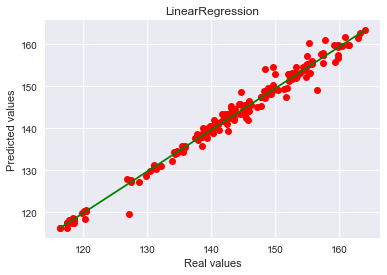


Lasso: 

score for validation set: 0.985185761643


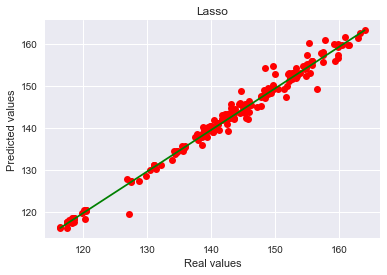


Ridge: 

score for validation set: 0.985160965763


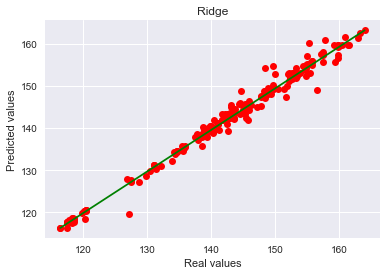


r2 score for average predictions: 0.984815292507

mean squared error for average predictions: 1.99798446349


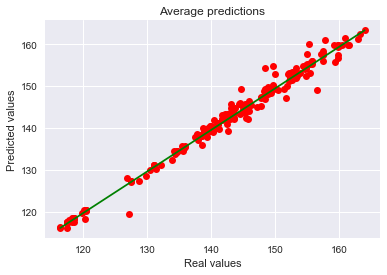

In [10]:
import os
model_filenames = []
for file in os.listdir('.'):
    if file.endswith(".pkl"):
        model_filenames.append(file)

print(model_filenames)

estimators = []
for filename in model_filenames:
    estimators.append(joblib.load(filename))

pred = su.calculate_predictions_for_dataset(dataset=valid_dataset, estimators=estimators, plot_and_print=True)

## Calculate predictions

In [12]:
dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

#calculate the predicted prices
pred = su.calculate_predictions_for_dataset(dataset=dataset, estimators=estimators, plot_and_print=False)

#add the predicted prices to the dataset
dataset['Predicted Price'] = pred

#limit at which to buy
upper_limit = 0.05
#limit at which to sell
lower_limit = 0.05
#tolerance for the difference between the rolling mean and the adjusted close
rm_tol = 0.001

signaller_params = {\
                   'upper_limit' : upper_limit, \
                    'lower_limit' : lower_limit, \
                    'rm_tol' : rm_tol \
                   }

#calculate trade signals based on different indicators and add those signals to the dataframe
signaller = sg.Signaller(signaller_params)

dataset = signaller.calculate_trade_signal(dataset)

dataset[:100]

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,RM Signal,Percentage Signal,BB Signal,Trade Signal
2010-01-06,27.550818,27.660055,27.084312,27.112585,-0.015906,27.434641,27.072225,27.797058,-0.014205,27.062465,27.073698,-1,0,0,-1
2010-01-07,27.212826,27.244955,26.865839,27.062465,-0.001849,27.346481,26.870781,27.822180,-0.016027,27.242385,27.046193,-1,0,0,-1
2010-01-08,27.026481,27.244955,26.867124,27.242385,0.006648,27.294304,26.848286,27.740322,-0.009486,27.242385,27.240333,-1,0,0,-1
2010-01-09,27.026481,27.244955,26.867124,27.242385,0.000000,27.242127,26.862194,27.622061,-0.009486,27.242385,27.169853,-1,0,0,-1
2010-01-10,27.026481,27.244955,26.867124,27.242385,0.000000,27.180441,27.007138,27.353743,-0.011195,27.002063,27.167649,0,0,0,0
2010-01-11,27.347766,27.373469,26.788730,27.002063,-0.008822,27.158336,26.924232,27.392441,-0.004076,26.694915,26.958722,-1,0,0,-1
2010-01-12,26.883831,26.958369,26.527847,26.694915,-0.011375,27.084826,26.601759,27.567894,-0.013582,27.071461,26.603525,-1,0,0,-1
2010-01-13,26.714192,27.107445,26.229695,27.071461,0.014106,27.050642,26.600236,27.501047,-0.006274,26.914674,27.064854,0,0,0,0
2010-01-14,27.002063,27.047043,26.861983,26.914674,-0.005792,26.985100,26.581233,27.388966,-0.012029,26.464875,26.877808,-1,0,0,-1
2010-01-15,27.107445,27.193549,26.457164,26.464875,-0.016712,26.829598,26.332967,27.326229,-0.028540,26.464875,26.466352,-1,0,0,-1


## Calculate trade signals based on the predictions

In [13]:
#add the predicted prices to the dataset
dataset['Predicted Price'] = pred

#limit at which to buy
upper_limit = 0.01
#limit at which to sell
lower_limit = 0.01
#tolerance for the difference between the rolling mean and the adjusted close
rm_tol = 0.005

signaller_params = {\
                    'upper_limit' : upper_limit, \
                    'lower_limit' : lower_limit, \
                    'rm_tol' : rm_tol \
                   }

#calculate trade signals based on different indicators and add those signals to the dataframe
signaller = sg.Signaller(signaller_params)

dataset = signaller.calculate_trade_signal(dataset)

dataset[:100]

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,RM Signal,Percentage Signal,BB Signal,Trade Signal
2010-01-06,27.550818,27.660055,27.084312,27.112585,-0.015906,27.434641,27.072225,27.797058,-0.014205,27.062465,27.073698,-1,0,0,-1
2010-01-07,27.212826,27.244955,26.865839,27.062465,-0.001849,27.346481,26.870781,27.822180,-0.016027,27.242385,27.046193,-1,0,0,-1
2010-01-08,27.026481,27.244955,26.867124,27.242385,0.006648,27.294304,26.848286,27.740322,-0.009486,27.242385,27.240333,0,0,0,0
2010-01-09,27.026481,27.244955,26.867124,27.242385,0.000000,27.242127,26.862194,27.622061,-0.009486,27.242385,27.169853,0,0,0,0
2010-01-10,27.026481,27.244955,26.867124,27.242385,0.000000,27.180441,27.007138,27.353743,-0.011195,27.002063,27.167649,0,0,0,0
2010-01-11,27.347766,27.373469,26.788730,27.002063,-0.008822,27.158336,26.924232,27.392441,-0.004076,26.694915,26.958722,-1,0,0,-1
2010-01-12,26.883831,26.958369,26.527847,26.694915,-0.011375,27.084826,26.601759,27.567894,-0.013582,27.071461,26.603525,-1,0,0,-1
2010-01-13,26.714192,27.107445,26.229695,27.071461,0.014106,27.050642,26.600236,27.501047,-0.006274,26.914674,27.064854,0,0,0,0
2010-01-14,27.002063,27.047043,26.861983,26.914674,-0.005792,26.985100,26.581233,27.388966,-0.012029,26.464875,26.877808,0,0,0,0
2010-01-15,27.107445,27.193549,26.457164,26.464875,-0.016712,26.829598,26.332967,27.326229,-0.028540,26.464875,26.466352,-1,0,0,-1


## Find the best trading strategy for the trade signals

In [15]:
#risk behaviour levels for buying stocks: the higher the value, the higher the confidence that the signal is correct
buy_risk_levels = {'high' : 1, 'moderate' : 2, 'low' : 3}

#risk behaviour levels for selling stocks: the lower the value, the higher the confidence that the signal is correct
sell_risk_levels = {'low' : -3, 'moderate' : -2, 'high' : -1}

debug_flag = False

initial_funds = 100000

trader_configurations = [\
                         #balanced trader
                         {'name' : 'Balanced Trader', \
                          'buy_risk' : buy_risk_levels['moderate'], \
                          'sell_risk' : sell_risk_levels['moderate'], \
                          'use_signal_strength' : True, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bearish trader
                         {'name' : 'Bearish Trader', \
                          'buy_risk' : buy_risk_levels['low'], \
                          'sell_risk' : sell_risk_levels['high'], \
                          'use_signal_strength' : False,
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bullish trader
                         {'name' : 'Bullish Trader', \
                          'buy_risk' : buy_risk_levels['high'], \
                          'sell_risk' : sell_risk_levels['low'], \
                          'use_signal_strength' : True, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         }\
                        ]

trade_df = dataset[['Adj. Close', 'Trade Signal']]

highest_profit = 0
best_trader = None

for config in trader_configurations:
    trader = tr.Trader(config)
    trader.trade(trade_df)
    
    if trader.profit > highest_profit:
        highest_profit = trader.profit
        best_trader = config['name']
    
print('Best trader for current stock market data is : {0}'.format(best_trader))

Balanced Trader starts trading
After 25 transactions, Balanced Trader exits his position with a profit of 126.18%

Bearish Trader starts trading
After 0 transactions, Bearish Trader exits his position with a profit of 0.00%

Bullish Trader starts trading
After 33 transactions, Bullish Trader exits his position with a profit of 323.51%

Best trader for current stock market data is : Bullish Trader


## Identify the market trends using unsupervised learning

In [12]:
rs = 42 # random state
symbol = 'AAPL'
window = 5
look_ahead = 1
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2017, 8, 31)

all_dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

labels_to_drop = [\
                  'Future Price', \
                  'Daily return', \
                 'Rolling mean {0}'.format(window), \
                 'Lower Bollinger band {0}'.format(window), \
                 'Upper Bollinger band {0}'.format(window), \
                 'Cummulative return {0}'.format(window) \
#                   'Adj. Open', \
#                   'Adj. High', \
#                   'Adj. Low'\
                 ]
dataset = all_dataset.drop(labels=labels_to_drop, axis=1)
target = all_dataset['Future Price']

dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close
2010-01-06,27.550818,27.660055,27.084312,27.112585
2010-01-07,27.212826,27.244955,26.865839,27.062465
2010-01-08,27.026481,27.244955,26.867124,27.242385
2010-01-09,27.026481,27.244955,26.867124,27.242385
2010-01-10,27.026481,27.244955,26.867124,27.242385


In [14]:
regimes_number = 4
best_mix = GaussianMixture(random_state=rs, n_components=regimes_number, covariance_type='spherical')

best_mix.fit(dataset)
regime = best_mix.predict(dataset)

regimes = pd.DataFrame(regime, columns = ['Regime'], index = dataset.index)
dataset = dataset.join(target)

dataset['Return'] = np.log(dataset['Future Price'] / dataset['Adj. Close'])

regimes = regimes.join(dataset)
regimes = regimes.assign(market_cu_return=regimes.Return.cumsum())
regimes['Date'] = regimes.index
regimes.head()

,Regime,Adj. Open,Adj. High,Adj. Low,Adj. Close,Future Price,Return,market_cu_return,Date
2010-01-06,2,27.550818,27.660055,27.084312,27.112585,27.062465,-0.001850,-0.001850,2010-01-06
2010-01-07,2,27.212826,27.244955,26.865839,27.062465,27.242385,0.006626,0.004776,2010-01-07
2010-01-08,2,27.026481,27.244955,26.867124,27.242385,27.242385,0.000000,0.004776,2010-01-08
2010-01-09,2,27.026481,27.244955,26.867124,27.242385,27.242385,0.000000,0.004776,2010-01-09
2010-01-10,2,27.026481,27.244955,26.867124,27.242385,27.002063,-0.008861,-0.004085,2010-01-10


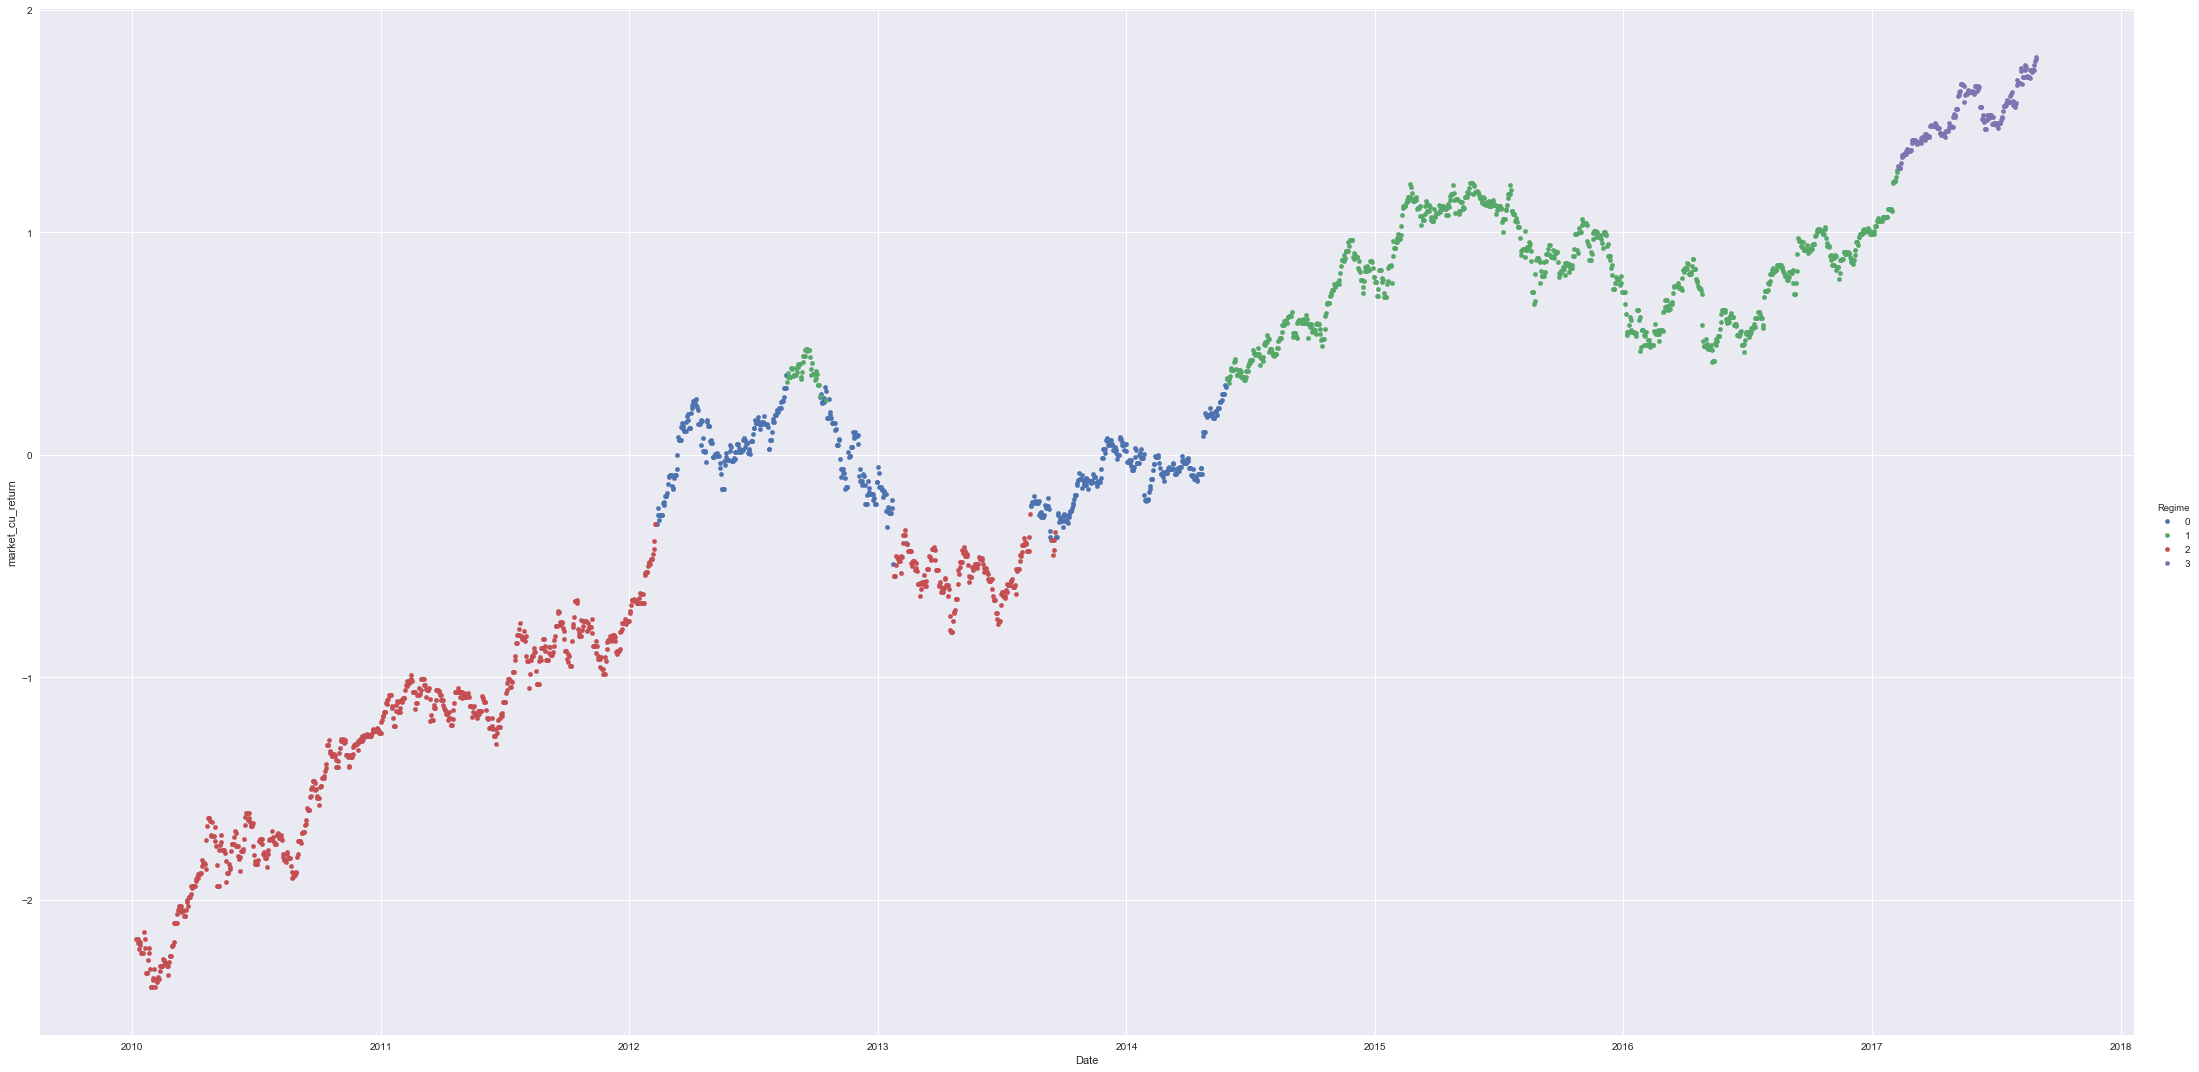

In [27]:
order = np.arange(0, regimes_number)
fig = sns.FacetGrid(data=regimes, hue='Regime', hue_order=order, aspect=2, size=15)
fig.map(plt.pyplot.scatter, 'Date', 'market_cu_return', s=20).add_legend()
plt.pyplot.show()

In [28]:
for i in order:
    print('Mean for regime {0}: {1}'.format(i, best_mix.means_[i][0]))
    print('Co-variance for regime {0}: {1}\n'.format(i, best_mix.covariances_[i]))

Mean for regime 0: 72.2510498942
Co-variance for regime 0: 26.0392622199

Mean for regime 1: 105.349929124
Co-variance for regime 1: 132.221860826

Mean for regime 2: 44.3657054411
Co-variance for regime 2: 102.042863593

Mean for regime 3: 146.134348616
Co-variance for regime 3: 60.130281676



Regime 0: Low mean and Low covariance.

Regime 1: High mean and High covariance.

Regime 2: Low mean and High covariance.

Regime 3: High mean and Low covariance.

In [29]:
scaler = StandardScaler()

reg = regimes.copy()
columns = reg.columns.drop(['Regime','Date'])    
reg[columns]= scaler.fit_transform(regimes[columns])
reg['Signal'] = 0
reg.loc[reg['Return'] > 0, 'Signal'] = 1
reg.loc[reg['Return'] < 0, 'Signal'] = -1
reg['return'] = reg['Return'].shift(1)
reg = reg.dropna()

reg.head()

,Regime,Adj. Open,Adj. High,Adj. Low,Adj. Close,Future Price,Return,market_cu_return,Date,Signal,return
2010-01-08,2,-1.604459,-1.607513,-1.596337,-1.596092,-1.596489,-0.048144,-2.177637,2010-01-08,-1,0.446391
2010-01-09,2,-1.604459,-1.607513,-1.596337,-1.596092,-1.596489,-0.048144,-2.177637,2010-01-09,-1,-0.048144
2010-01-10,2,-1.604459,-1.607513,-1.596337,-1.596092,-1.603715,-0.709439,-2.197204,2010-01-10,-1,-0.048144
2010-01-11,2,-1.594786,-1.603668,-1.598711,-1.603323,-1.612952,-0.901949,-2.222467,2010-01-11,-1,-0.709439
2010-01-12,2,-1.608754,-1.616087,-1.606612,-1.612566,-1.601628,0.997226,-2.191535,2010-01-12,1,-0.901949


In [30]:
X = reg.drop(['Signal','Return','market_cu_return','Date'], axis=1)
y = reg['Signal']

split2 = int(.8 * len(reg))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X[:split2]
y_train = y[:split2]

X_test = X[split2:]
y_test = y[split2:]

print ('Training set has {0} samples.'.format(X_train.shape[0]))
print ('Testing set has {0} samples.'.format(X_test.shape[0]))

# clf = SVC(random_state = 42)
# clf_params = {'C' : [0.1, 1, 10, 100], \
#              'tol' : [0.1, 0.01, 0.001, 0.0001]}

# cv_splits = cross_val_splits(data, n_splits = 5)
# grid_search = GridSearchCV(clf, clf_params, cv = cv_splits)

clf.fit(X_train, y_train)

p_data = len(X) - split2

dataset['Pred_Signal'] = 0
dataset.iloc[-p_data:, dataset.columns.get_loc('Pred_Signal')] = clf.predict(X_test)

print(dataset['Pred_Signal'][-p_data:])

dataset['str_ret'] = dataset['Pred_Signal'] * dataset['Return'].shift(-1)


Training set has 2233 samples.
Testing set has 559 samples.
2016-02-19   -1
2016-02-20   -1
2016-02-21   -1
2016-02-22   -1
2016-02-23   -1
2016-02-24   -1
2016-02-25   -1
2016-02-26   -1
2016-02-27   -1
2016-02-28   -1
2016-02-29   -1
2016-03-01   -1
2016-03-02   -1
2016-03-03   -1
2016-03-04   -1
2016-03-05   -1
2016-03-06   -1
2016-03-07   -1
2016-03-08   -1
2016-03-09   -1
2016-03-10   -1
2016-03-11   -1
2016-03-12   -1
2016-03-13   -1
2016-03-14   -1
2016-03-15   -1
2016-03-16   -1
2016-03-17   -1
2016-03-18   -1
2016-03-19   -1
             ..
2017-08-01   -1
2017-08-02   -1
2017-08-03   -1
2017-08-04   -1
2017-08-05   -1
2017-08-06   -1
2017-08-07   -1
2017-08-08   -1
2017-08-09   -1
2017-08-10   -1
2017-08-11   -1
2017-08-12   -1
2017-08-13   -1
2017-08-14   -1
2017-08-15   -1
2017-08-16   -1
2017-08-17   -1
2017-08-18   -1
2017-08-19   -1
2017-08-20   -1
2017-08-21   -1
2017-08-22   -1
2017-08-23   -1
2017-08-24   -1
2017-08-25   -1
2017-08-26   -1
2017-08-27   -1
2017-08-28  

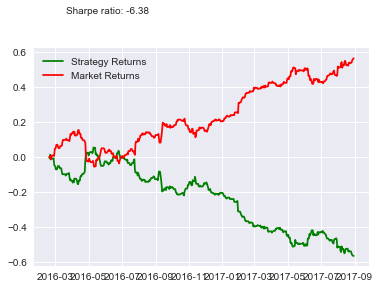

In [34]:
dataset['strategy_cu_return']=0.
dataset['market_cu_return']=0.
dataset.iloc[-p_data:,dataset.columns.get_loc('strategy_cu_return')] \
       = np.nancumsum(dataset['str_ret'][-p_data:])
dataset.iloc[-p_data:,dataset.columns.get_loc('market_cu_return')] \
       = np.nancumsum(dataset['Return'][-p_data:])
sharpe = (dataset['strategy_cu_return'][-1]-dataset['market_cu_return'][-1])\
           /np.nanstd(dataset['strategy_cu_return'][-p_data:])

pl.plot(dataset['strategy_cu_return'][-p_data:],color='g',label='Strategy Returns')
pl.plot(dataset['market_cu_return'][-p_data:],color='r',label='Market Returns')
pl.figtext(0.2,1, s='Sharpe ratio: %.2f'%sharpe)
pl.legend(loc='best')
pl.show()